# PN2V Training
Here we will use the estimated noise model (from ```03a_CreateNoiseModel_GMM``` or ```03b_CreateNoiseModel_Histogram```) and train a PN2V network on single noisy images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  https://owncloud.mpi-cbg.de/index.php/s/224xGSeHquMbQYu and created a noise model (either GMM based or histogram based, using either the notebook ```03a_CreateNoiseModel_GMM.ipynb``` or ```03b_CreateNoiseModel_Histogram.ipynb```). Ensure that for Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif``` and not the slide edge data. For your dataset, ensure that you load the right data. 

In [2]:
path='../../data/Mouse skull nuclei/'
# Load the training data
data=imread(path+'example2_digital_offset300.tif')
typeNoiseModel='GMM' # Specify either 'GMM' or 'histogram'

In [3]:
if (typeNoiseModel == 'GMM'):
    n_gaussian = 3 # If using GMM noise model, specify number of Gaussians created in 03a_CreateNoiseModel_GMM.ipynb
    n_coeff = 2 # If using GMM noise model, specify number of coefficients created in 03a_CreateNoiseModel_GMM.ipynb
dataName = 'mouseskullnuclei' # dataname chosen in `03x_CreateNoiseModel_GMM.ipynb`. This is used to load the right noise model.
mode = 'bootstrap' # Either 'bootstrap'(bootstrapping mode) or 'calibration'(using calibration data)

In [4]:
if(typeNoiseModel=='GMM'):
    namePN2VModel=dataName+'_GMM_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode
    params= np.load(path+'trained_weights_minSignal_maxSignal_GMM_'+dataName+'_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     torch.Tensor(params['trained_weight']))
else:
    namePN2VModel=dataName+'_histogram_'+mode
    histogram = np.load(path+'noiseModelHistogram_'+ dataName+'_'+mode+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

../../unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
../../unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Epoch 0 finished      
avg. loss: 8.800867748260497+-(2SEM)0.054103835397970285      
Epoch 1 finished      
avg. loss: 8.320021963119506+-(2SEM)0.048684517540452714      
Epoch 2 finished      
avg. loss: 8.10890212059021+-(2SEM)0.037658194426126335      
Epoch 3 finished      
avg. loss: 7.982277727127075+-(2SEM)0.03859300951338872      
Epoch 4 finished      
avg. loss: 7.886218476295471+-(2SEM)0.0432389220362214      
Epoch 5 finished      
avg. loss: 7.774803519248962+-(2SEM)0.05445814870953039      
Epoch 6 finished      
avg. loss: 7.771893239021301+-(2SEM)0.060942878099555044      
Epoch 7 finished      
avg. loss: 7.711070847511292+-(2SEM)0.08196297281397612      
Epoch 8 finished      
avg. loss: 7.639041304588318+-(2SEM)0.05689610646211139      
Epoch 9 finished      
avg. loss: 7.589431738853454+-(2SEM)0.0611966959544477      
Epoch 10 finished      
avg. loss: 7.560915684700012+-(2SEM)0.07010427366113227      
Epoch 11 finished      
avg. loss: 7.494637775421142+-(2SEM)0.0

Epoch 92 finished      
avg. loss: 7.445291900634766+-(2SEM)0.06472909379309237      
Epoch 93 finished      
avg. loss: 7.422602939605713+-(2SEM)0.08635264872358075      
Epoch 94 finished      
avg. loss: 7.474629211425781+-(2SEM)0.0764112095715729      
Epoch 95 finished      
avg. loss: 7.626496839523315+-(2SEM)0.06571821194236264      
Epoch 96 finished      
avg. loss: 7.466546964645386+-(2SEM)0.07860952151431516      
Epoch 97 finished      
avg. loss: 7.508765244483948+-(2SEM)0.07964322547716489      
Epoch 98 finished      
avg. loss: 7.468525362014771+-(2SEM)0.09084547686199873      
Epoch    98: reducing learning rate of group 0 to 1.5625e-05.
Epoch 99 finished      
avg. loss: 7.490201759338379+-(2SEM)0.08074237785315821      
Epoch 100 finished      
avg. loss: 7.504549217224121+-(2SEM)0.06896150301067532      
Epoch 101 finished      
avg. loss: 7.491353845596313+-(2SEM)0.07196396829741603      
Epoch 102 finished      
avg. loss: 7.554970622062683+-(2SEM)0.05760143975474

Epoch 181 finished      
avg. loss: 7.485729718208313+-(2SEM)0.07910657610669372      
Epoch 182 finished      
avg. loss: 7.422152709960938+-(2SEM)0.06338323101034128      
Epoch 183 finished      
avg. loss: 7.480857253074646+-(2SEM)0.05842158997335957      
Epoch 184 finished      
avg. loss: 7.477292466163635+-(2SEM)0.0745781464773442      
Epoch 185 finished      
avg. loss: 7.467601776123047+-(2SEM)0.04586508241740328      
Epoch 186 finished      
avg. loss: 7.502406716346741+-(2SEM)0.06433446601955099      
Epoch   186: reducing learning rate of group 0 to 6.1035e-08.
Epoch 187 finished      
avg. loss: 7.520106220245362+-(2SEM)0.06782155931384481      
Epoch 188 finished      
avg. loss: 7.516155934333801+-(2SEM)0.061475122432750044      
Epoch 189 finished      
avg. loss: 7.508846855163574+-(2SEM)0.08332110482161802      
Epoch 190 finished      
avg. loss: 7.419625234603882+-(2SEM)0.07856538954782667      
Epoch 191 finished      
avg. loss: 7.4204028129577635+-(2SEM)0.0722

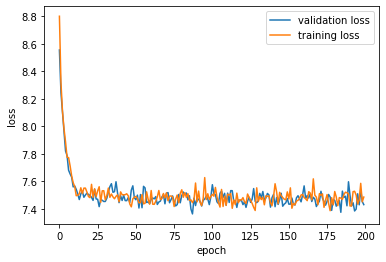

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()